In [2]:
import torch
from binNF.normalizing_flows.manager import *
import matplotlib.pyplot as plt
import numpy as np
import torch.multiprocessing as mp


In [2]:
def step(x):
    a=torch.zeros_like(x[:,0])
    b=torch.ones_like(x[:,0])
   
    return torch.where(torch.max(abs(x[:,0]), abs(x[:,1]))>1,a,b)

def g(x): #box: expect 0.25 in dim2
   
    q=torch.max(torch.abs(x),dim=-1).values
  
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
   
    return torch.where(q<0.5,a,b)

def gaussian(x):
    return torch.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.3**2)) 

def camel(x):
    return torch.exp( -((x[:,0]-0.75)**2+(x[:,1]-0.75)**2)/(0.2**2))+torch.exp( -((x[:,0]-0.25)**2+(x[:,1]-0.25)**2)/(0.2**2))

def gaussianb(x):
    return torch.exp( -(x)**2)[:,0]

def gaussianbnp(x):
    return np.exp( -((x[:,0]+1)**2+(x[:,1])**2) )

def gaussiannp(x):
    return np.exp( -(x[:,0])**2 )

def con(x):
    y=torch.empty(x.shape[0])
    return y.fill_(5)

def sin(x):
    return 2+torch.sin(x[:,1])

def lin(x):
    return 0.2*x[:,0]+0.5

def sinnp(x):
    return 2+np.sin(x[:,1])

def tanp(r):
    return (1+((torch.tan((r-0.5)*np.pi))**2))*np.pi

In [3]:
n_flow = 2      # number of dimensions

 
# We define our NormalizingFlow object 
NF =  PWQuadManager(n_flow=n_flow)



In [4]:
#The model is created
NF.create_model(n_pass_through=1,n_cells=2, n_bins=15, NN=[8,8,8,8,8,8,8], roll_step=1) 
optim = torch.optim.Adamax(NF._model.parameters(),lr=0.000405, weight_decay=2.5e-07) 


#do other improvements, test without cuda, save stuff, CUDA, git, start hypopt




In [5]:

history=NF._train_variance_forward_seq(camel,optim,"./logs/tmp/",10000,1000,0,True, True,True)


In [6]:

print('Initial loss')
print(NF.int_loss)
print('Epoch of best result')
print(NF.best_epoch)
print('Best loss')
print(NF.best_loss)
print('Best loss relative')
print(NF.best_loss_rel)
print('Function evaluations')
print(NF.best_func_count)
"""      
#print(NF.model)
losses=[]
for key, value in NF.history.items():
    losses.append(value["loss"])

fig = plt.figure(figsize=(12, 4))
a1=fig.add_subplot(131)
plt.plot(losses)

a1.title.set_text('Loss')
a2=fig.add_subplot(132)
plt.plot(np.sqrt(np.exp(losses)))
a2.title.set_text('Standard Deviation')

"""




Initial loss
tensor(0.1624, grad_fn=<MeanBackward0>)
Epoch of best result
368
Best loss
tensor(0.0476, grad_fn=<MeanBackward0>)
Best loss relative
tensor(0.2932, grad_fn=<DivBackward0>)
Function evaluations
3700000


'      \n#print(NF.model)\nlosses=[]\nfor key, value in NF.history.items():\n    losses.append(value["loss"])\n\nfig = plt.figure(figsize=(12, 4))\na1=fig.add_subplot(131)\nplt.plot(losses)\n\na1.title.set_text(\'Loss\')\na2=fig.add_subplot(132)\nplt.plot(np.sqrt(np.exp(losses)))\na2.title.set_text(\'Standard Deviation\')\n\n'

In [11]:

w = torch.empty(40, NF.n_flow)
torch.nn.init.uniform_(w)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w,torch.device("cpu")))

#print("mapped")
#print(NF.format_input(100*torch.tan((w-0.5)*(np.pi))))
XJ=NF.model(NF.format_input(w,torch.device("cpu")))


                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian

XJ2=NF.best_model(NF.format_input(w,torch.device("cpu")))


                    # Separate the points and their Jacobians:
print("XJ2")
print(XJ2)

"""
f=gaussian
print("f(x)")
print(f(X))


print("fXJ")
print(torch.mul(f(X), XJ[:, -1]))

print("loss without jac")
print(torch.mean(f(X)**2))

print("squared mean")
print(torch.mean(f(X))**2)

print("loss")
print(torch.mean(torch.mul(f(X), XJ[:, -1])**2))

"""

W
tensor([[0.8735, 0.8214],
        [0.3355, 0.7534],
        [0.3476, 0.9583],
        [0.6777, 0.0925],
        [0.5267, 0.8377],
        [0.0271, 0.6551],
        [0.2251, 0.5799],
        [0.8015, 0.2300],
        [0.6072, 0.7349],
        [0.7512, 0.8764],
        [0.7042, 0.7676],
        [0.1980, 0.8055],
        [0.2014, 0.2365],
        [0.1202, 0.4900],
        [0.5486, 0.8155],
        [0.2920, 0.0696],
        [0.2912, 0.3334],
        [0.2302, 0.3249],
        [0.1362, 0.2848],
        [0.0941, 0.2388],
        [0.5034, 0.8582],
        [0.4246, 0.2707],
        [0.7441, 0.9688],
        [0.3914, 0.8287],
        [0.7314, 0.9466],
        [0.3634, 0.6738],
        [0.5428, 0.6822],
        [0.9415, 0.6112],
        [0.9460, 0.2324],
        [0.8106, 0.2091],
        [0.9338, 0.6363],
        [0.6436, 0.8144],
        [0.9323, 0.7901],
        [0.3414, 0.5618],
        [0.8846, 0.1560],
        [0.5221, 0.2339],
        [0.4105, 0.2649],
        [0.7066, 0.6571],
        [0

'\nf=gaussian\nprint("f(x)")\nprint(f(X))\n\n\nprint("fXJ")\nprint(torch.mul(f(X), XJ[:, -1]))\n\nprint("loss without jac")\nprint(torch.mean(f(X)**2))\n\nprint("squared mean")\nprint(torch.mean(f(X))**2)\n\nprint("loss")\nprint(torch.mean(torch.mul(f(X), XJ[:, -1])**2))\n\n'

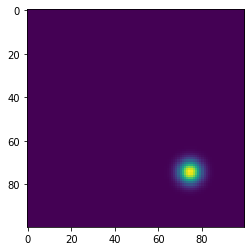

In [49]:
xs = np.linspace(-10,10,100)
ys = np.linspace(10,-10,100) # in images the y axis is inverted
Xs,Ys = np.meshgrid(xs,ys)
zs=gaussianbnp(np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)).reshape(100,100)
plt.imshow(zs)
plt.show()

In [22]:
print("reset")
NF.create_model(n_pass_through=1,n_cells=1,n_bins=10, nn_width=2, NN=[20,20,20], roll_step=0)

w = torch.empty(10000, NF.n_flow, requires_grad=True)
torch.nn.init.uniform_(w,0,1)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))
XJ = NF.model(NF.format_input(w))

                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian
X = ((XJ[:, :-1]).detach())
print("X")
print(X)
print("diff")
print(X[:,0]-w[:,1])
print("f(x)")
print(sin(X))

print("fXJ")
print(torch.mul(sin(X), XJ[:, -1]))

reset
W
tensor([[0.6108, 0.7451],
        [0.3028, 0.2412],
        [0.2823, 0.1151],
        ...,
        [0.5725, 0.1838],
        [0.8225, 0.9309],
        [0.1988, 0.2423]], requires_grad=True)
with jacob
tensor([[0.6108, 0.7451, 1.0000],
        [0.3028, 0.2412, 1.0000],
        [0.2823, 0.1151, 1.0000],
        ...,
        [0.5725, 0.1838, 1.0000],
        [0.8225, 0.9309, 1.0000],
        [0.1988, 0.2423, 1.0000]], grad_fn=<CatBackward>)
XJ
tensor([[0.6108, 0.7238, 0.7407],
        [0.3028, 0.2571, 1.1249],
        [0.2823, 0.1301, 1.1378],
        ...,
        [0.5725, 0.1827, 1.4329],
        [0.8225, 0.9263, 1.0666],
        [0.1988, 0.2883, 0.6346]], grad_fn=<CatBackward>)
X
tensor([[0.6108, 0.7238],
        [0.3028, 0.2571],
        [0.2823, 0.1301],
        ...,
        [0.5725, 0.1827],
        [0.8225, 0.9263],
        [0.1988, 0.2883]])
diff
tensor([-0.1342,  0.0616,  0.1672,  ...,  0.3886, -0.1084, -0.0435],
       grad_fn=<SubBackward0>)
f(x)
tensor([2.6622, 2.2543, 

In [ ]:
"""
#a4=fig.add_subplot(143)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax.title.set_text('Jacobian after training')
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[5], roll_step=1)
rcParams['axes.labelpad'] = 800
z = torch.empty((10000,2)) 
torch.nn.init.uniform_(z,0,1)

w=NF.format_input(z)
X=NF.model(w).data.numpy()
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax1.title.set_text('Jacobian before training')
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)
#ax1.auto_scale_xyz([0.5, 2], [0, 1], [1.55, 1.75])
ax1.xaxis._axinfo['label']['space_factor'] = 4.8
ax1.zaxis._axinfo['label']['space_factor'] = 8.8
rcParams['axes.labelpad'] = 80

print("\n")
"""

tensor(0.0423, grad_fn=<MeanBackward0>)


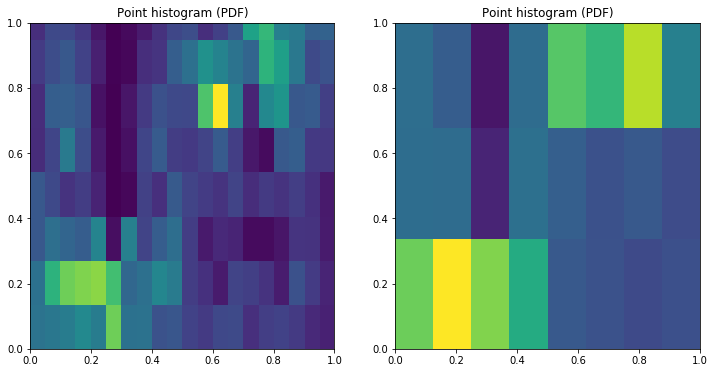

In [10]:
w = torch.empty((12100,2)) 
torch.nn.init.uniform_(w,0,1)
#q = torch.empty((12100,2)) 
#torch.nn.init.normal_(q,std=10)
#z=150*torch.tan((w-0.5)*(np.pi))


Y=NF.format_input(w, dev=torch.device("cpu"))
X=NF.model(Y)
XZ=NF.best_model(Y)
#Z=(torch.atan(X)/np.pi+0.5).data.numpy()
#print(Z)
X=X.data.numpy()
XX=XZ.data.numpy()
#z=z.data.numpy()
#a3=fig.add_subplot(133)
fig = plt.figure(figsize=(12, 6))
a3=fig.add_subplot(121)

plt.hist2d(XX[:,0],XX[:,1],bins=25)
axes = plt.gca()
axes.set_xlim([-0,1]) 
axes.set_ylim([-0,1])
#a3.set_aspect(aspect=1.)


a3.title.set_text('Point histogram (PDF)')
a3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


#fig = plt.figure(figsize=(6, 6))
a4=fig.add_subplot(122)
#plt.hist2d(X[:,0],X[:,1],bins=2500)
#Q=[[]]
#Q=[[-1,-1,-1],[2,2,2]]
#Q[:,1]=[,]
#Q=np.ones((10,2))
#Q[:,0]*=-1
plt.hist2d(XX[:,0],XX[:,1],bins=10)
axes = plt.gca()
axes.set_xlim([-0,1])
axes.set_ylim([-0,1])
#a3.set_aspect(aspect=1.)


a4.title.set_text('Point histogram (PDF)')
a4.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)



f=camel
loss=torch.mean((f(XZ[:,:2])*XZ[:,2])**2)
print(loss)

In [4]:
w = torch.empty(20, 2)
torch.nn.init.normal_(w, std=100)
w.device

device(type='cpu')

ValueError: not enough values to unpack (expected 2, got 1)